In [1]:
# =========================
# IMPORTS Y CONFIGURACIÓN
# =========================

# -----------------------------
# Librerías estándar
# -----------------------------
import os                 # Manejo de rutas y directorios
import json               # Guardar/rescatar datos en formato JSON
import numpy as np        # Cálculos numéricos y arrays
import pandas as pd       # Manipulación de DataFrames

# -----------------------------
# Librerías estadísticas y econométricas
# -----------------------------
import statsmodels.api as sm                          # Modelos de regresión y análisis estadístico
from statsmodels.stats.diagnostic import het_breuschpagan  # Prueba de heterocedasticidad
from statsmodels.stats.stattools import durbin_watson      # Prueba de autocorrelación residual
from scipy import stats                               # Funciones estadísticas (tests, distribuciones)

# -----------------------------
# Librerías de visualización
# -----------------------------
import matplotlib.pyplot as plt  # Graficación básica
import seaborn as sns            # Visualización avanzada con estilo estético

# -----------------------------
# Librerías para finanzas
# -----------------------------
import yfinance as yf            # Descarga de datos financieros de Yahoo Finance

# -----------------------------
# Configuración de estilo de gráficos
# -----------------------------
sns.set(style="whitegrid")       # Estilo de fondo blanco con cuadrícula sutil para gráficas

# -----------------------------
# Configuración de directorios de trabajo
# -----------------------------
NOTEBOOK_DIR = os.getcwd()       # Directorio actual del notebook
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)   # Carpeta raíz del proyecto
PROCESSED_DIR = os.path.join(PROJECT_ROOT, "data", "processed")  # Carpeta para datos procesados
REG_DIR = os.path.join(PROCESSED_DIR, "regression")              # Carpeta específica para regresiones
PLOTS_DIR = os.path.join(REG_DIR, "plots")                        # Carpeta para guardar gráficos

# Crear directorios si no existen
os.makedirs(REG_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

# Confirmación visual al usuario
print("Resultados de regresión se guardarán en:", REG_DIR)


Resultados de regresión se guardarán en: c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\data\processed\regression


In [2]:
# =========================
# CARGAR DATOS PROCESADOS
# =========================

# -----------------------------
# Cargar panel de datos mensual
# -----------------------------
# Este dataset contiene series temporales mensuales de cada empresa del Tech30,
# incluyendo retornos, fechas y otras métricas financieras.
panel_df = pd.read_csv(
    os.path.join(PROCESSED_DIR, "tech30_panel_monthly_2018_2024.csv"),
    parse_dates=['Date']  # Convertir la columna 'Date' a tipo datetime para análisis temporal
)

# -----------------------------
# Cargar estadísticas agregadas
# -----------------------------
# Este dataset contiene estadísticas resumidas por empresa, como media, volatilidad y beta
# para el periodo 2018-2024.
agg_df = pd.read_csv(
    os.path.join(PROCESSED_DIR, "tech30_aggregated_stats_2018_2024.csv")
)

# -----------------------------
# Chequeo rápido de integridad
# -----------------------------
# Imprime el número de filas y columnas para cada DataFrame, confirmando que se cargaron correctamente
print("Panel mensual:", panel_df.shape)
print("Dataset agregado:", agg_df.shape)


Panel mensual: (2403, 6)
Dataset agregado: (30, 7)


In [3]:
# =========================
# RETORNOS DEL MERCADO
# =========================

# -----------------------------
# Descargar precios históricos de QQQ
# -----------------------------
# Este ETF representa el mercado tecnológico (NASDAQ-100). Se descargan datos diarios
# desde 2018 hasta 2024 como fallback si no existe la variable previamente calculada.
market = yf.download(
    "QQQ",
    start="2018-01-01",
    end="2024-12-31",
    progress=False  # Evita la barra de progreso en notebooks
)

# -----------------------------
# Selección de columna de precios
# -----------------------------
# Se prioriza el precio ajustado ("Adj Close") para considerar splits y dividendos.
# Si no existe, se utiliza "Close" como alternativa.
price_col = "Adj Close" if "Adj Close" in market.columns else "Close"

# -----------------------------
# Cálculo de retornos logarítmicos diarios
# -----------------------------
# Retornos logarítmicos: ln(P_t / P_(t-1))
market["MarketReturn"] = np.log(market[price_col] / market[price_col].shift(1))

# -----------------------------
# Resampleo a retornos mensuales
# -----------------------------
# Se toma el precio del último día de cada mes para obtener retornos mensuales.
# Posteriormente se eliminan valores faltantes.
market = market.resample("ME").last()[["MarketReturn"]].dropna()

# -----------------------------
# Formateo de índice de fechas
# -----------------------------
# Convertimos a string para consistencia con panel_df y merges posteriores
market.index = market.index.strftime("%Y-%m-%d")

# -----------------------------
# Chequeo rápido de integridad
# -----------------------------
print("MarketReturn listo:", market.shape)


MarketReturn listo: (84, 1)


In [4]:
# =========================
# REGRESIÓN LINEAL SIMPLE - RESPONDE A P3
# Pregunta: ¿La correlación con el mercado explica la volatilidad?
# Modelo: Volatility = β₀ + β₁ × Correlation_Market + ε
# =========================

print("=" * 60)
print("ANÁLISIS DE REGRESIÓN LINEAL SIMPLE (P3)")
print("Objetivo: Modelar Volatilidad en función de Correlación con Mercado")
print("=" * 60)

# Verificación y normalización de la estructura de 'market'
# - Detecta y aplana MultiIndex en columnas si es necesario.
# - Garantiza que 'market' sea un DataFrame con columna 'MarketReturn'.
# - Convierte el índice a formato string 'YYYY-MM-DD' para merges consistentes.
print("\n🔍 Verificando estructura de 'market'...")
print(f"   Tipo de columnas: {type(market.columns)}")
print(f"   Columnas actuales: {market.columns}")
print(f"   Shape: {market.shape}")

if isinstance(market.columns, pd.MultiIndex):
    print("⚠️  market tiene MultiIndex. Corrigiendo...")
    if 'MarketReturn' in market.columns.get_level_values(0):
        market = market['MarketReturn'].copy()
    elif ('MarketReturn', '') in market.columns:
        market = market[('MarketReturn', '')].copy()
    else:
        print("   ⚠️  No se encuentra 'MarketReturn', usando primera columna")
        market = market.iloc[:, 0].copy()
    print("   ✅ MultiIndex eliminado")

if isinstance(market, pd.Series):
    market = market.to_frame(name='MarketReturn')
    print("   ✅ Convertido a DataFrame")

if market.columns[0] != 'MarketReturn':
    market.columns = ['MarketReturn']
    print("   ✅ Columna renombrada a 'MarketReturn'")

if len(market) > 0:
    if not isinstance(market.index[0], str):
        print("   ⚠️  Convirtiendo índice a string...")
        market.index = pd.to_datetime(market.index).strftime("%Y-%m-%d")
        print("   ✅ Índice convertido a formato YYYY-MM-DD")

print(f"\n✅ Estructura final de market:")
print(f"   Shape: {market.shape}")
print(f"   Columnas: {market.columns.tolist()}")
print(f"   Tipo índice: {type(market.index[0]) if len(market) > 0 else 'vacío'}")
print(f"   Primeras 3 fechas: {market.index[:3].tolist()}")
print("=" * 60)

# Calcular correlación de retornos con el mercado para cada empresa
# - Asegura formato de fecha en panel_df.
# - Hace merge por fecha con la serie de retornos de mercado.
# - Sólo calcula correlación cuando hay suficiente observaciones (≥ 12).
print("\n📊 Calculando correlaciones individuales con QQQ...")

correlations = []
failed_companies = []

for company in sorted(panel_df["Company"].unique()):
    try:
        df_i = panel_df[panel_df["Company"] == company].copy()
        df_i["Date"] = df_i["Date"].astype(str)

        if len(df_i) > 0:
            sample_date = df_i["Date"].iloc[0]
            if len(sample_date) > 10:  # si contiene timestamp
                df_i["Date"] = pd.to_datetime(df_i["Date"]).dt.strftime("%Y-%m-%d")

        df_merged = (
            df_i.merge(market, left_on="Date", right_index=True, how="inner")
                .dropna(subset=["Return", "MarketReturn"])
        )

        # Pearson sobre retornos emparejados en tiempo
        if len(df_merged) >= 12:  # umbral práctico: ~1 año de datos
            corr = df_merged["Return"].corr(df_merged["MarketReturn"])
            correlations.append({
                "Company": company,
                "Corr_Market": corr,
                "n_obs": len(df_merged)
            })
        else:
            failed_companies.append(f"{company} (solo {len(df_merged)} obs)")

    except Exception as e:
        # Guardar la empresa que falló para diagnóstico posterior
        failed_companies.append(f"{company} (error: {str(e)[:30]})")
        continue

corr_df = pd.DataFrame(correlations)

print(f"✅ Correlaciones calculadas para {len(corr_df)} empresas")
if len(corr_df) > 0:
    print(f"   Rango: [{corr_df['Corr_Market'].min():.3f}, {corr_df['Corr_Market'].max():.3f}]")
    print(f"   Media: {corr_df['Corr_Market'].mean():.3f}")
    print(f"   Mediana: {corr_df['Corr_Market'].median():.3f}")

if failed_companies:
    print(f"\n⚠️  No se calculó correlación para {len(failed_companies)} empresas:")
    for fc in failed_companies[:5]:
        print(f"   • {fc}")
    if len(failed_companies) > 5:
        print(f"   ... y {len(failed_companies)-5} más")

# Preparar dataset de regresión combinando estadísticas agregadas y correlaciones
# - Verifica que agg_df contenga las variables requeridas.
# - Hace inner join para quedarse sólo con empresas presentes en ambos conjuntos.
print(f"\n📋 Preparando datos para regresión...")

required_cols = ["Company", "Volatility", "MeanReturn"]
missing_cols = [col for col in required_cols if col not in agg_df.columns]
if missing_cols:
    raise ValueError(f"❌ Faltan columnas en agg_df: {missing_cols}")

reg_data = (
    agg_df[required_cols]
    .merge(corr_df[["Company", "Corr_Market"]], on="Company", how="inner")
    .dropna()
)

print(f"✅ Datos para regresión: {len(reg_data)} empresas")
print(f"   Variables: Volatility (Y), Corr_Market (X)")

if len(reg_data) < 10:
    print(f"\n⚠️  ADVERTENCIA: Solo {len(reg_data)} observaciones.")
    print("   Se recomienda al menos 10-15 empresas para regresión confiable.")

# Estimación OLS robusta (HC1) del modelo lineal simple
X_simple = sm.add_constant(reg_data["Corr_Market"])
y_simple = reg_data["Volatility"]

model_simple = sm.OLS(y_simple, X_simple).fit(cov_type="HC1")

print("\n" + "=" * 60)
print("RESULTADOS DE LA REGRESIÓN LINEAL SIMPLE")
print("=" * 60)
print(model_simple.summary())

# Diagnósticos clásicos: autocorrelación y heterocedasticidad
resid = model_simple.resid
dw = durbin_watson(resid)
bp_stat, bp_p, _, _ = het_breuschpagan(resid, model_simple.model.exog)

print("\n" + "=" * 60)
print("DIAGNÓSTICOS DEL MODELO")
print("=" * 60)
print(f"Durbin-Watson (autocorrelación):     {dw:.4f}")
print(f"  → Interpretación: {'✅ Sin autocorrelación' if 1.5 < dw < 2.5 else '⚠️ Posible autocorrelación'}")
print(f"\nBreusch-Pagan (heterocedasticidad):  LM={bp_stat:.4f}, p={bp_p:.4f}")
print(f"  → Interpretación: {'✅ Homocedasticidad' if bp_p > 0.05 else '⚠️ Heterocedasticidad detectada (usamos errores robustos HC1)'}")

# Guardado de resultados numéricos y dataset utilizado
coef_df = pd.DataFrame({
    "Variable": model_simple.params.index,
    "Coeficiente": model_simple.params.values,
    "Std_Error": model_simple.bse.values,
    "t_value": model_simple.tvalues.values,
    "p_value": model_simple.pvalues.values,
    "IC_inferior": model_simple.conf_int()[0].values,
    "IC_superior": model_simple.conf_int()[1].values
})
coef_df.to_csv(os.path.join(REG_DIR, "P3_simple_regression_coefficients.csv"), index=False)

summary_dict = {
    "modelo": "Volatility ~ Corr_Market",
    "n_observaciones": int(model_simple.nobs),
    "R2": float(model_simple.rsquared),
    "R2_ajustado": float(model_simple.rsquared_adj),
    "F_statistic": float(model_simple.fvalue),
    "F_pvalue": float(model_simple.f_pvalue),
    "AIC": float(model_simple.aic),
    "BIC": float(model_simple.bic),
    "coeficientes": {
        "intercepto": {
            "valor": float(model_simple.params["const"]),
            "std_error": float(model_simple.bse["const"]),
            "t_value": float(model_simple.tvalues["const"]),
            "p_value": float(model_simple.pvalues["const"]),
            "IC_95": [float(model_simple.conf_int().loc["const", 0]),
                      float(model_simple.conf_int().loc["const", 1])]
        },
        "Corr_Market": {
            "valor": float(model_simple.params["Corr_Market"]),
            "std_error": float(model_simple.bse["Corr_Market"]),
            "t_value": float(model_simple.tvalues["Corr_Market"]),
            "p_value": float(model_simple.pvalues["Corr_Market"]),
            "IC_95": [float(model_simple.conf_int().loc["Corr_Market", 0]),
                      float(model_simple.conf_int().loc["Corr_Market", 1])]
        }
    },
    "diagnosticos": {
        "Durbin_Watson": float(dw),
        "Breusch_Pagan_LM": float(bp_stat),
        "Breusch_Pagan_p": float(bp_p)
    }
}

with open(os.path.join(REG_DIR, "P3_simple_regression_summary.json"), "w") as f:
    json.dump(summary_dict, f, indent=4)

reg_data.to_csv(os.path.join(REG_DIR, "P3_regression_data.csv"), index=False)

print("\n✅ Archivos guardados:")
print(f"   📄 {os.path.join(REG_DIR, 'P3_simple_regression_coefficients.csv')}")
print(f"   📄 {os.path.join(REG_DIR, 'P3_simple_regression_summary.json')}")
print(f"   📄 {os.path.join(REG_DIR, 'P3_regression_data.csv')}")

# Interpretación automatizada de resultados
beta1 = model_simple.params["Corr_Market"]
p_val = model_simple.pvalues["Corr_Market"]
r2 = model_simple.rsquared

print("\n" + "=" * 60)
print("INTERPRETACIÓN DE RESULTADOS")
print("=" * 60)
print(f"📊 Ecuación estimada:")
print(f"   Volatility = {model_simple.params['const']:.6f} + {beta1:.6f} × Corr_Market")
print(f"\n📈 Estadísticos clave:")
print(f"   Coeficiente β₁ (pendiente): {beta1:.6f}")
print(f"   Error estándar: {model_simple.bse['Corr_Market']:.6f}")
print(f"   Estadístico t: {model_simple.tvalues['Corr_Market']:.4f}")
print(f"   P-value: {p_val:.4f}")
print(f"   R²: {r2:.4f} ({r2*100:.2f}%)")

print(f"\n🎯 Significancia estadística:")
if p_val < 0.01:
    print(f"   ✅ ALTAMENTE SIGNIFICATIVO (p < 0.01)")
elif p_val < 0.05:
    print(f"   ✅ SIGNIFICATIVO (p < 0.05)")
elif p_val < 0.10:
    print(f"   ⚠️  MARGINALMENTE SIGNIFICATIVO (0.05 < p < 0.10)")
else:
    print(f"   ❌ NO SIGNIFICATIVO (p ≥ 0.10)")

if p_val < 0.05:
    print(f"\n💡 Interpretación práctica:")
    print(f"   • Por cada incremento de 0.1 en la correlación con el mercado (QQQ),")
    print(f"     la volatilidad {'aumenta' if beta1 > 0 else 'disminuye'} en promedio {abs(beta1*0.1):.5f} unidades")
    print(f"     (equivalente a {abs(beta1*0.1)*100:.3f} puntos porcentuales).")
    print(f"\n   • El modelo explica {r2*100:.2f}% de la variación en volatilidad.")
    print(f"     {'✅ Buen ajuste' if r2 > 0.5 else '⚠️ Ajuste moderado' if r2 > 0.3 else '⚠️ Ajuste bajo'}")
    
    corr_ejemplo = 0.7
    vol_pred = model_simple.params["const"] + beta1 * corr_ejemplo
    print(f"\n   • Ejemplo: Una empresa con correlación {corr_ejemplo} tendría")
    print(f"     volatilidad estimada de {vol_pred:.4f} ({vol_pred*100:.2f}%)")
else:
    print(f"\n⚠️  Conclusión:")
    print(f"   No hay evidencia estadística suficiente (α=0.05) de que la correlación")
    print(f"   con el mercado explique linealmente la volatilidad de las empresas tech.")
    print(f"\n   Posibles razones:")
    print(f"   • Relación no lineal entre las variables")
    print(f"   • Variables omitidas importantes (tamaño, sector, apalancamiento)")
    print(f"   • Muestra pequeña (n={int(model_simple.nobs)})")
    print(f"   • Alta heterogeneidad entre empresas tecnológicas")

print("\n" + "=" * 60)


ANÁLISIS DE REGRESIÓN LINEAL SIMPLE (P3)
Objetivo: Modelar Volatilidad en función de Correlación con Mercado

🔍 Verificando estructura de 'market'...
   Tipo de columnas: <class 'pandas.core.indexes.multi.MultiIndex'>
   Columnas actuales: MultiIndex([('MarketReturn', '')],
           names=['Price', 'Ticker'])
   Shape: (84, 1)
⚠️  market tiene MultiIndex. Corrigiendo...
   ✅ MultiIndex eliminado
   ✅ Convertido a DataFrame

✅ Estructura final de market:
   Shape: (84, 1)
   Columnas: ['MarketReturn']
   Tipo índice: <class 'str'>
   Primeras 3 fechas: ['2018-01-31', '2018-02-28', '2018-03-31']

📊 Calculando correlaciones individuales con QQQ...
✅ Correlaciones calculadas para 30 empresas
   Rango: [0.009, 0.320]
   Media: 0.197
   Mediana: 0.214

📋 Preparando datos para regresión...
✅ Datos para regresión: 30 empresas
   Variables: Volatility (Y), Corr_Market (X)

RESULTADOS DE LA REGRESIÓN LINEAL SIMPLE
                            OLS Regression Results                            
D

In [5]:
# =========================
# REGRESIONES CAPM POR EMPRESA (BETAS INDIVIDUALES)
# Modelo por empresa: Return_it = α + β × MarketReturn_t + γ × log(Volume_it) + ε_it
# =========================

# Asegurar directorios de salida (no cambia la lógica, solo garantiza existencia de carpetas)
os.makedirs(REG_DIR, exist_ok=True)
os.makedirs(PLOTS_DIR, exist_ok=True)

print("=" * 60)
print("REGRESIONES INDIVIDUALES POR EMPRESA (TIPO CAPM)")
print("Objetivo: Estimar beta (sensibilidad al mercado) para cada empresa")
print("=" * 60)

# Función que estima la regresión por empresa
def estimate_company_regression(company, panel_df, market_returns):
    """
    Estima una regresión tipo CAPM para una única empresa:
      Return_it = α + β * MarketReturn_t + γ * log(Volume_it) + ε_it

    Entradas:
      - company: nombre de la empresa (string)
      - panel_df: DataFrame con columnas mínimas: Company, Date, Return, Volume
      - market_returns: DataFrame o Serie indexada por fecha con la columna 'MarketReturn'

    Salida:
      - dict con estadísticas clave (coeficientes, errores estándar, p-values, R², diagnósticos)
      - devuelve None si no hay suficientes observaciones (umbral: 12)
    """
    # Filtrar el panel para la empresa y normalizar la fecha
    df_i = panel_df[panel_df["Company"] == company].copy()
    df_i["Date"] = df_i["Date"].astype(str)

    # Merge temporal con la serie de retornos de mercado (alineamiento por fecha)
    df = df_i.merge(
        market_returns,
        left_on="Date",
        right_index=True,
        how="inner"
    ).dropna(subset=["Return", "MarketReturn", "Volume"])

    # Requerir un número mínimo de observaciones para estimar (práctica: ≥ 12 meses)
    if len(df) < 12:
        return None

    # Transformación del volumen: log(Volume)
    # - reemplace 0 por NaN para evitar -inf, luego rellenar valores faltantes
    df["logVol"] = np.log(df["Volume"].replace(0, np.nan)).ffill().bfill()

    # Variables explicativas y respuesta
    X = sm.add_constant(df[["MarketReturn", "logVol"]])
    y = df["Return"]

    # Estimación OLS con errores robustos (HC1) para manejar heterocedasticidad potencial
    model = sm.OLS(y, X).fit(cov_type="HC1")

    # Diagnósticos básicos de residuos
    resid = model.resid
    dw = durbin_watson(resid)                       # autocorrelación de primer orden aproximada
    bp_stat, bp_p, _, _ = het_breuschpagan(resid, model.model.exog)  # heterocedasticidad

    # Compilar resultados clave en un diccionario plano (fácil de convertir a DataFrame)
    return {
        "Company": company,
        "n_obs": len(df),
        "Intercept": float(model.params.get("const", np.nan)),
        "Coef_Market": float(model.params.get("MarketReturn", np.nan)),
        "SE_Market": float(model.bse.get("MarketReturn", np.nan)),
        "p_Market": float(model.pvalues.get("MarketReturn", np.nan)),
        "Coef_logVol": float(model.params.get("logVol", np.nan)),
        "SE_logVol": float(model.bse.get("logVol", np.nan)),
        "p_logVol": float(model.pvalues.get("logVol", np.nan)),
        "R2": float(model.rsquared),
        "DW": float(dw),
        "BP_stat": float(bp_stat),
        "BP_p": float(bp_p)
    }

# Comprobaciones y normalizaciones de la estructura de la serie de mercado
print("\n📊 Verificando estructura de market...")
print(f"   Tipo de columnas: {type(market.columns)}")
print(f"   Columnas actuales: {market.columns}")

# Si existe MultiIndex en las columnas, seleccionar/convertir explícitamente la columna de interés
if isinstance(market.columns, pd.MultiIndex):
    print("⚠️  market tiene MultiIndex. Aplanando...")
    # Intentar varias formas de localizar la columna 'MarketReturn'
    if ('MarketReturn', '') in market.columns:
        market = market[('MarketReturn', '')].to_frame(name='MarketReturn')
    elif 'MarketReturn' in market.columns.get_level_values(0):
        market = market['MarketReturn'].copy()
        if isinstance(market, pd.Series):
            market = market.to_frame(name='MarketReturn')
    else:
        # Si no se localiza explícitamente, tomar la primera columna como fallback
        market = market.iloc[:, 0].to_frame(name='MarketReturn')
    print("✅ MultiIndex eliminado")

# Asegurar que market sea un DataFrame con la columna 'MarketReturn'
if isinstance(market, pd.Series):
    market = market.to_frame(name='MarketReturn')

if len(market.columns) == 1 and market.columns[0] != 'MarketReturn':
    market.columns = ['MarketReturn']

# Asegurar formato del índice para merges (YYYY-MM-DD strings)
if len(market) > 0 and not isinstance(market.index[0], str):
    print("⚠️  Convirtiendo índice a string...")
    market.index = pd.to_datetime(market.index).strftime("%Y-%m-%d")

print(f"✅ Estructura final: {market.shape}, columnas: {market.columns.tolist()}")
print(f"✅ Índice tipo: {type(market.index[0]) if len(market) > 0 else 'vacío'}")
print("=" * 60)

# Ejecutar la estimación por empresa (bucle principal)
company_rows = []
companies = sorted(panel_df["Company"].unique())
n_companies = len(companies)

print(f"\n🔄 Estimando regresiones para {n_companies} empresas...\n")

for i, company in enumerate(companies, 1):
    # Mensaje de progreso periódico para seguimiento
    if i % 5 == 0 or i == n_companies:
        print(f"   Procesando: {i}/{n_companies} empresas...")

    res = estimate_company_regression(company, panel_df, market)

    if res is None:
        # Notificar empresas con datos insuficientes
        print(f"   ⚠️  {company}: Insuficientes datos (< 12 meses)")
        continue

    company_rows.append(res)

# Guardar resultados consolidados si hay estimaciones válidas
if company_rows:
    company_reg_df = pd.DataFrame(company_rows)
    out_path = os.path.join(REG_DIR, "company_monthly_regression_results.csv")
    company_reg_df.to_csv(out_path, index=False)

    print("\n" + "=" * 60)
    print("✅ REGRESIONES COMPLETADAS")
    print("=" * 60)
    print(f"Empresas procesadas: {company_reg_df.shape[0]}/{n_companies}")
    print(f"📁 Archivo guardado: {out_path}")

    # Resumen rápido de la distribución de betas
    print("\n📊 RESUMEN DE COEFICIENTES BETA (sensibilidad al mercado):")
    print(f"   Media:    {company_reg_df['Coef_Market'].mean():.4f}")
    print(f"   Mediana:  {company_reg_df['Coef_Market'].median():.4f}")
    print(f"   Desv.Est: {company_reg_df['Coef_Market'].std():.4f}")
    print(f"   Mínimo:   {company_reg_df['Coef_Market'].min():.4f} ({company_reg_df.loc[company_reg_df['Coef_Market'].idxmin(), 'Company']})")
    print(f"   Máximo:   {company_reg_df['Coef_Market'].max():.4f} ({company_reg_df.loc[company_reg_df['Coef_Market'].idxmax(), 'Company']})")

    # Conteo de betas estadísticamente significativas al nivel 5%
    significant = (company_reg_df['p_Market'] < 0.05).sum()
    print(f"\n   Betas significativas (p < 0.05): {significant}/{len(company_reg_df)} ({significant/len(company_reg_df)*100:.1f}%)")

    # Resumen de goodness-of-fit
    print(f"\n📈 BONDAD DE AJUSTE:")
    print(f"   R² promedio: {company_reg_df['R2'].mean():.4f}")
    print(f"   R² mediano:  {company_reg_df['R2'].median():.4f}")

else:
    # Mensaje claro si ninguna regresión fue estimada; guía para diagnóstico
    print("\n❌ ERROR: No se pudieron calcular regresiones para ninguna empresa")
    print("   Verifica que panel_df y market tengan datos compatibles")

# Generación de gráficos diagnósticos para una muestra representativa (6 empresas)
print("\n" + "=" * 60)
print("GENERANDO GRÁFICOS DIAGNÓSTICOS")
print("=" * 60)

plot_sample = 6
plotted = 0

# Selección: 3 empresas con mayor beta y 3 con menor beta (si hay resultados)
if company_rows:
    top_companies = company_reg_df.nlargest(3, 'Coef_Market')['Company'].tolist()
    bottom_companies = company_reg_df.nsmallest(3, 'Coef_Market')['Company'].tolist()
    selected_companies = top_companies + bottom_companies
else:
    selected_companies = sorted(panel_df["Company"].unique())[:plot_sample]

for company in selected_companies:
    if plotted >= plot_sample:
        break

    # Preparar datos y volver a alinear con market
    df_i = panel_df[panel_df["Company"] == company].copy()
    df_i["Date"] = df_i["Date"].astype(str)

    df = df_i.merge(
        market,
        left_on="Date",
        right_index=True,
        how="inner"
    ).dropna(subset=["Return", "MarketReturn", "Volume"])

    # Requerir suficiente historial para producir gráficos diagnósticos significativos
    if df.shape[0] < 12:
        continue

    # Transformación de volumen consistente con la regresión
    df["logVol"] = np.log(df["Volume"].replace(0, np.nan)).ffill().bfill()

    # Estimación puntual para el gráfico
    X = sm.add_constant(df[["MarketReturn", "logVol"]])
    y = df["Return"]
    model = sm.OLS(y, X).fit(cov_type="HC1")
    resid = model.resid
    fitted = model.fittedvalues

    # Figura con tres paneles: (1) scatter + línea de regresión, (2) residuales vs fitted, (3) Q-Q plot
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Scatter retornos vs market + línea de regresión
    axes[0].scatter(df["MarketReturn"], df["Return"], alpha=0.6, s=50,
                    edgecolors='black', linewidth=0.5)
    xvals = np.linspace(df["MarketReturn"].min(), df["MarketReturn"].max(), 50)
    yvals = model.params.get("const", 0) + model.params.get("MarketReturn", 0) * xvals
    axes[0].plot(xvals, yvals, color="red", linewidth=2, label='Regresión')
    axes[0].set_title(f"{company}\nReturn vs MarketReturn", fontweight='bold')
    axes[0].set_xlabel("Market Return")
    axes[0].set_ylabel("Company Return")
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Anotar beta y R² en el gráfico para facilitar interpretación visual
    beta = model.params.get("MarketReturn", 0)
    r2 = model.rsquared
    axes[0].text(0.05, 0.95, f"β = {beta:.3f}\nR² = {r2:.3f}",
                 transform=axes[0].transAxes, fontsize=10,
                 verticalalignment='top',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    # Residuales vs fitted para comprobar patrones sistemáticos
    axes[1].scatter(fitted, resid, alpha=0.6, s=50,
                    edgecolors='black', linewidth=0.5)
    axes[1].axhline(0, color='red', linestyle='--', linewidth=2)
    axes[1].set_title("Residuales vs Valores Ajustados", fontweight='bold')
    axes[1].set_xlabel("Valores Ajustados")
    axes[1].set_ylabel("Residuales")
    axes[1].grid(True, alpha=0.3)

    # Q-Q plot para evaluación visual de normalidad de residuos
    sm.qqplot(resid, line='s', ax=axes[2])
    axes[2].set_title("Q-Q Plot (Normalidad)", fontweight='bold')
    axes[2].grid(True, alpha=0.3)

    # Guardar figura y cerrar para liberar memoria
    plt.tight_layout()
    plot_path = os.path.join(PLOTS_DIR, f"{company}_CAPM_diagnostic.png")
    plt.savefig(plot_path, dpi=150, bbox_inches='tight')
    plt.close(fig)

    plotted += 1
    print(f"   ✅ Plot generado: {company}")

print(f"\n📁 {plotted} gráficos guardados en: {PLOTS_DIR}")
print("=" * 60)


REGRESIONES INDIVIDUALES POR EMPRESA (TIPO CAPM)
Objetivo: Estimar beta (sensibilidad al mercado) para cada empresa

📊 Verificando estructura de market...
   Tipo de columnas: <class 'pandas.core.indexes.base.Index'>
   Columnas actuales: Index(['MarketReturn'], dtype='object')
✅ Estructura final: (84, 1), columnas: ['MarketReturn']
✅ Índice tipo: <class 'str'>

🔄 Estimando regresiones para 30 empresas...

   Procesando: 5/30 empresas...
   Procesando: 10/30 empresas...
   Procesando: 15/30 empresas...
   Procesando: 20/30 empresas...
   Procesando: 25/30 empresas...
   Procesando: 30/30 empresas...

✅ REGRESIONES COMPLETADAS
Empresas procesadas: 30/30
📁 Archivo guardado: c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\data\processed\regression\company_monthly_regression_results.csv

📊 RESUMEN DE COEFICIENTES BETA (sensibilidad al mercado):
   Media:    1.4332
   Mediana:  1.4091
   Desv.Est: 0.7610
   Mínimo:   -0.6622 (Palantir)
   Máximo:   2.8205 (Spotify)

   Betas significa

Generando visualizaciones para regresión lineal simple (P3)...


C:\Users\admin\AppData\Local\Temp\ipykernel_19836\1221925223.py:105: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\admin\AppData\Local\Temp\ipykernel_19836\1221925223.py:106: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  plt.savefig(os.path.join(PLOTS_DIR, "P3_regression_diagnostics.png"),
c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


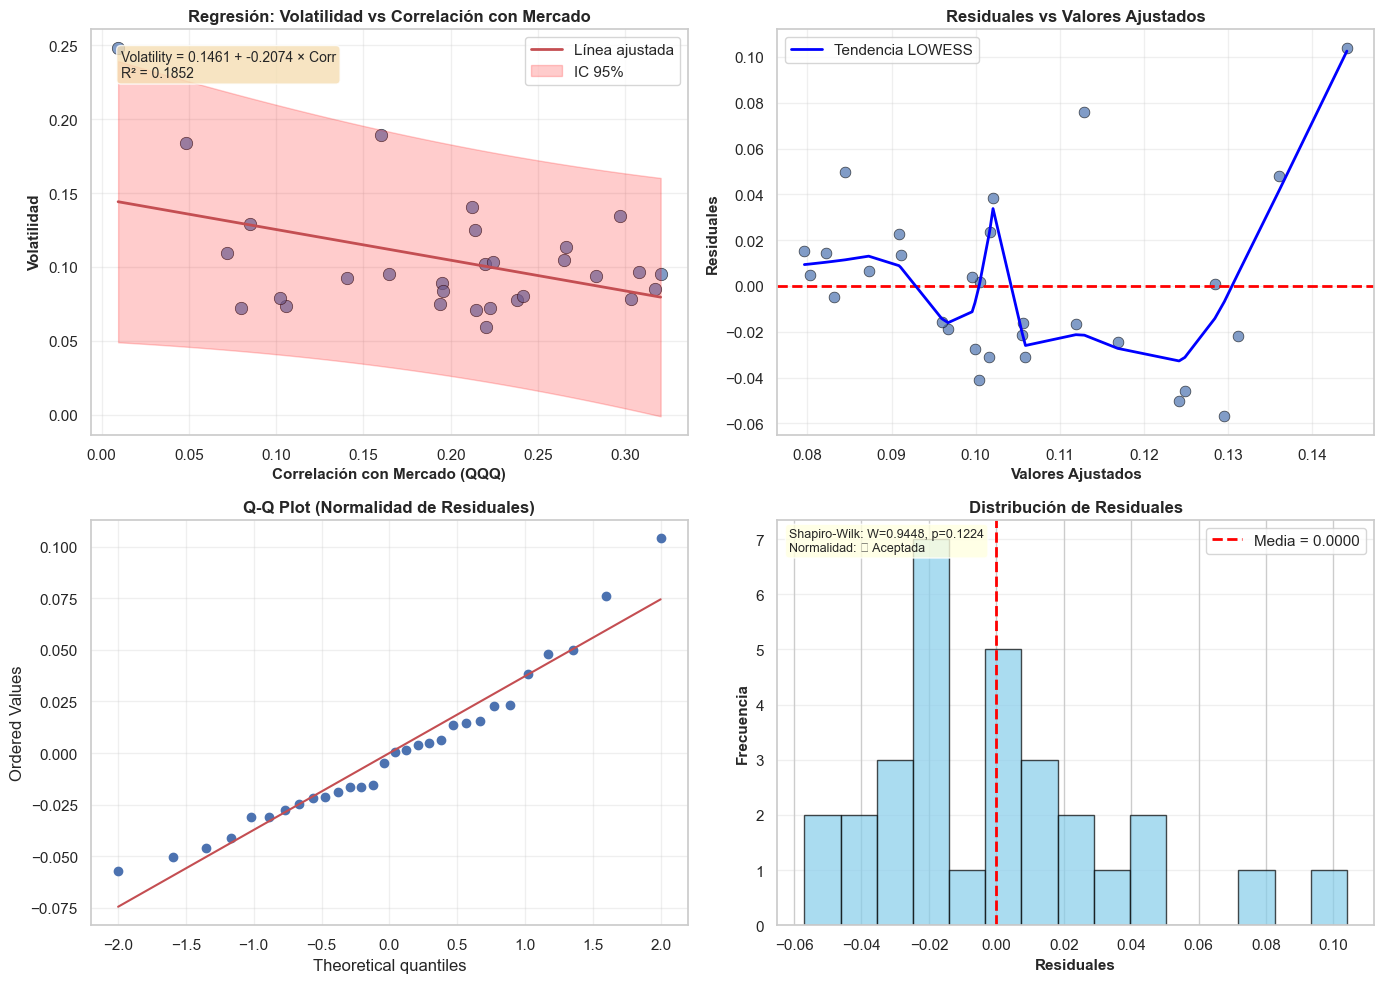


✅ Gráfico guardado: c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\data\processed\regression\plots\P3_regression_diagnostics.png


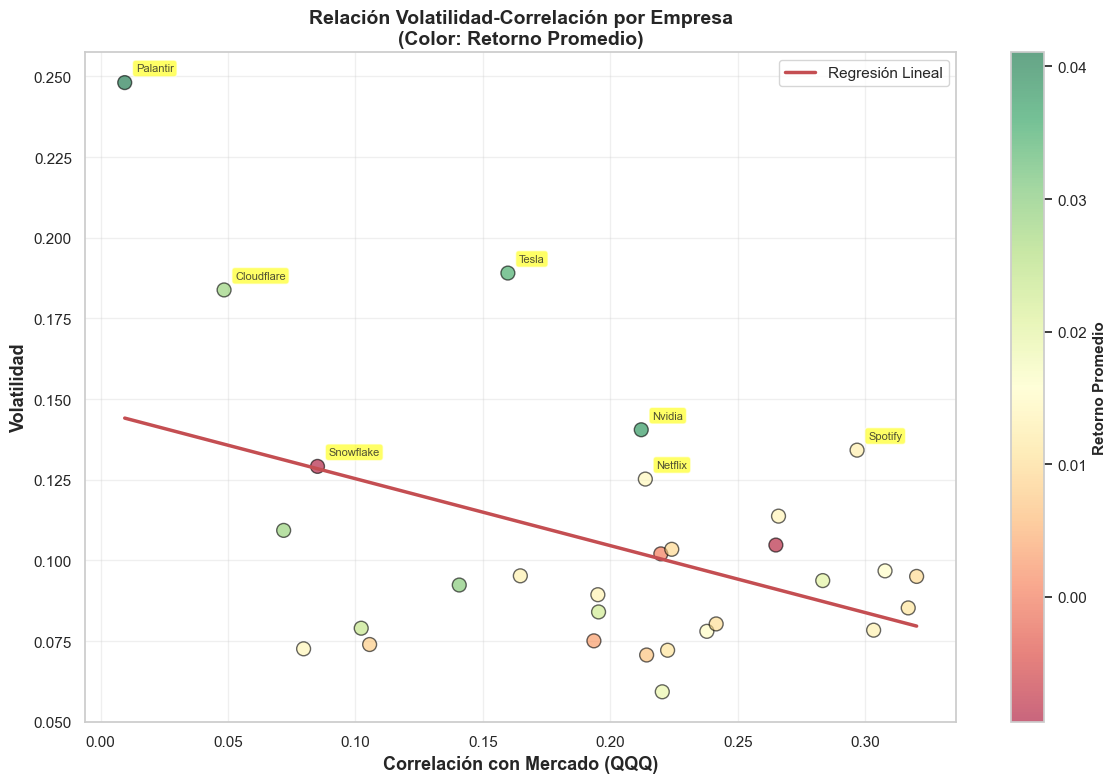

✅ Gráfico guardado: c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\data\processed\regression\plots\P3_companies_labeled.png

TABLA RESUMEN PARA DIAPOSITIVAS
     Estadístico     Valor
    N (empresas)        30
              R²    0.1852
     R² ajustado    0.1561
     F-statistic    3.0625
p-value (modelo)    0.0911
 β₀ (intercepto)  0.146068
β₁ (Corr_Market) -0.207438
    p-value (β₁)    0.0801

✅ Tabla guardada: c:\Users\admin\Desktop\Estadistica\AlphaTech-Analyzer\data\processed\regression\P3_summary_table.csv


In [6]:
# =========================
# CELDA 7: VISUALIZACIONES PARA P3
# Objetivo: generar gráficos diagnósticos y tablas resumen para la regresión
# simple Volatility ~ Corr_Market (ayuda a la interpretación y presentación)
# =========================

print("Generando visualizaciones para regresión lineal simple (P3)...")

# Recrear el modelo a partir de los datos en memoria para que la celda sea ejecutable de forma independiente.
# Se usa cov_type="HC1" para que los intervalos y p-values reflejen errores robustos.
X_simple = sm.add_constant(reg_data["Corr_Market"])
y_simple = reg_data["Volatility"]
model_simple = sm.OLS(y_simple, X_simple).fit(cov_type="HC1")

# ----------------------------------------------------------
# FIGURA 1: Panel de diagnósticos (scatter + residuales + QQ + hist)
# - Proporciona una vista compacta de ajuste, patrones en residuos y normalidad
# ----------------------------------------------------------
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Scatter: Volatilidad vs Correlación con línea de regresión y banda IC 95%
ax1 = axes[0, 0]
ax1.scatter(reg_data["Corr_Market"], reg_data["Volatility"],
            alpha=0.7, s=80, edgecolors='black', linewidth=0.5)

# Línea de regresión predicha
x_line = np.linspace(reg_data["Corr_Market"].min(),
                     reg_data["Corr_Market"].max(), 100)
y_line = model_simple.params["const"] + model_simple.params["Corr_Market"] * x_line
ax1.plot(x_line, y_line, 'r-', linewidth=2, label='Línea ajustada')

# Banda de predicción / intervalo de confianza aproximado
from statsmodels.sandbox.regression.predstd import wls_prediction_std
_, lower, upper = wls_prediction_std(model_simple,
                                     exog=sm.add_constant(x_line.reshape(-1, 1)))
ax1.fill_between(x_line, lower, upper, alpha=0.2, color='red',
                 label='IC 95%')

ax1.set_xlabel('Correlación con Mercado (QQQ)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Volatilidad', fontsize=11, fontweight='bold')
ax1.set_title('Regresión: Volatilidad vs Correlación con Mercado',
              fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Añadir la ecuación estimada y R² en el panel para referencia rápida
eq_text = f"Volatility = {model_simple.params['const']:.4f} + {model_simple.params['Corr_Market']:.4f} × Corr\n"
eq_text += f"R² = {model_simple.rsquared:.4f}"
ax1.text(0.05, 0.95, eq_text, transform=ax1.transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

# ----------------------------------------------------------
# Residuales vs valores ajustados: buscar heterocedasticidad y patrones no-lineales
# - Se añade una curva LOWESS para detectar tendencias sistemáticas en los residuos.
# ----------------------------------------------------------
ax2 = axes[0, 1]
fitted = model_simple.fittedvalues
residuals = model_simple.resid

ax2.scatter(fitted, residuals, alpha=0.7, s=60, edgecolors='black', linewidth=0.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=2)
ax2.set_xlabel('Valores Ajustados', fontsize=11, fontweight='bold')
ax2.set_ylabel('Residuales', fontsize=11, fontweight='bold')
ax2.set_title('Residuales vs Valores Ajustados', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

from statsmodels.nonparametric.smoothers_lowess import lowess
smoothed = lowess(residuals, fitted, frac=0.3)
ax2.plot(smoothed[:, 0], smoothed[:, 1], 'blue', linewidth=2, label='Tendencia LOWESS')
ax2.legend()

# ----------------------------------------------------------
# Q-Q plot: evaluación visual de la normalidad de residuos
# - Útil para interpretar tests de inferencia y la validez de intervalos clásicos
# ----------------------------------------------------------
ax3 = axes[1, 0]
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot (Normalidad de Residuales)',
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)

# ----------------------------------------------------------
# Histograma de residuos + resultado de Shapiro-Wilk
# - Complementa el Q-Q plot con una prueba formal de normalidad
# ----------------------------------------------------------
ax4 = axes[1, 1]
ax4.hist(residuals, bins=15, edgecolor='black', alpha=0.7, color='skyblue')
ax4.axvline(residuals.mean(), color='red', linestyle='--', linewidth=2,
            label=f'Media = {residuals.mean():.4f}')
ax4.set_xlabel('Residuales', fontsize=11, fontweight='bold')
ax4.set_ylabel('Frecuencia', fontsize=11, fontweight='bold')
ax4.set_title('Distribución de Residuales', fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Test de normalidad: Shapiro-Wilk (sensible a tamaños pequeños/medianos)
stat, p_shapiro = stats.shapiro(residuals)
text_norm = f"Shapiro-Wilk: W={stat:.4f}, p={p_shapiro:.4f}\n"
text_norm += "Normalidad: " + ("✅ Aceptada" if p_shapiro > 0.05 else "⚠️ Rechazada")
ax4.text(0.02, 0.98, text_norm, transform=ax4.transAxes,
         fontsize=9, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "P3_regression_diagnostics.png"),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Gráfico guardado: {os.path.join(PLOTS_DIR, 'P3_regression_diagnostics.png')}")

# ----------------------------------------------------------
# FIGURA 2: Scatter con empresas etiquetadas y color por Retorno Promedio
# - Facilita identificar empresas atípicas en correlación o volatilidad
# - Se etiquetan casos extremos para la presentación
# ----------------------------------------------------------
fig2, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(reg_data["Corr_Market"], reg_data["Volatility"],
                     s=100, alpha=0.6, c=reg_data["MeanReturn"],
                     cmap='RdYlGn', edgecolors='black', linewidth=1)

# Línea de regresión para referencia visual
x_line = np.linspace(reg_data["Corr_Market"].min(),
                     reg_data["Corr_Market"].max(), 100)
y_line = model_simple.params["const"] + model_simple.params["Corr_Market"] * x_line
ax.plot(x_line, y_line, 'r-', linewidth=2.5, label='Regresión Lineal')

# Etiquetar empresas extremas (heurística: |Corr| > 0.7 o Volatility alta)
for idx, row in reg_data.iterrows():
    if (abs(row["Corr_Market"]) > 0.7 or row["Volatility"] > 0.12):
        ax.annotate(row["Company"],
                    (row["Corr_Market"], row["Volatility"]),
                    xytext=(8, 8), textcoords='offset points',
                    fontsize=8, alpha=0.8,
                    bbox=dict(boxstyle='round,pad=0.3',
                              facecolor='yellow', alpha=0.6))

ax.set_xlabel('Correlación con Mercado (QQQ)', fontsize=13, fontweight='bold')
ax.set_ylabel('Volatilidad', fontsize=13, fontweight='bold')
ax.set_title('Relación Volatilidad-Correlación por Empresa\n(Color: Retorno Promedio)',
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

# Barra de color para interpretar la escala de retorno promedio
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Retorno Promedio', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(PLOTS_DIR, "P3_companies_labeled.png"),
            dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Gráfico guardado: {os.path.join(PLOTS_DIR, 'P3_companies_labeled.png')}")

# ----------------------------------------------------------
# TABLA RESUMEN: métricas clave para incluir en diapositivas o reportes
# - Formatea los números para presentación y guarda CSV para inclusión en slides
# ----------------------------------------------------------
print("\n" + "=" * 60)
print("TABLA RESUMEN PARA DIAPOSITIVAS")
print("=" * 60)

summary_table = pd.DataFrame({
    "Estadístico": [
        "N (empresas)",
        "R²",
        "R² ajustado",
        "F-statistic",
        "p-value (modelo)",
        "β₀ (intercepto)",
        "β₁ (Corr_Market)",
        "p-value (β₁)"
    ],
    "Valor": [
        f"{int(model_simple.nobs)}",
        f"{model_simple.rsquared:.4f}",
        f"{model_simple.rsquared_adj:.4f}",
        f"{model_simple.fvalue:.4f}",
        f"{model_simple.f_pvalue:.4f}",
        f"{model_simple.params['const']:.6f}",
        f"{model_simple.params['Corr_Market']:.6f}",
        f"{model_simple.pvalues['Corr_Market']:.4f}"
    ]
})

# Mostrar tabla en consola para revisión rápida
print(summary_table.to_string(index=False))

# Guardar tabla para uso en presentaciones
summary_table.to_csv(os.path.join(REG_DIR, "P3_summary_table.csv"), index=False)
print(f"\n✅ Tabla guardada: {os.path.join(REG_DIR, 'P3_summary_table.csv')}")
